In [1]:
# Standard scientific Python imports
import matplotlib.pyplot as plt
import numpy as np
from time import time
import pickle

import sklearn.gaussian_process as gp
import sklearn.gaussian_process.kernels as ker

from sklearn import pipeline
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.kernel_approximation import (RBFSampler, Nystroem)
from sklearn.preprocessing import StandardScaler

# Base functions

In [2]:
## Constant for Cost function
THRESHOLD = 0.5
W1 = 1
W2 = 20
W3 = 100
W4 = 0.04


def cost_function(true, predicted):
    """
        true: true values in 1D numpy array
        predicted: predicted values in 1D numpy array

        return: float
    """
    cost = (true - predicted)**2

    # true above threshold (case 1)
    mask = true >= THRESHOLD
    mask_w1 = np.logical_and(predicted>=true,mask)
    mask_w2 = np.logical_and(np.logical_and(predicted<true,predicted > THRESHOLD),mask)
    mask_w3 = np.logical_and(predicted<=THRESHOLD,mask)

    cost[mask_w1] = cost[mask_w1]*W1
    cost[mask_w2] = cost[mask_w2]*W2
    cost[mask_w3] = cost[mask_w3]*W3

    # true value below threshold (case 2)
    mask = true < THRESHOLD
    mask_w1 = np.logical_and(predicted>true,mask)
    mask_w2 = np.logical_and(predicted<=true,mask)

    cost[mask_w1] = cost[mask_w1]*W1
    cost[mask_w2] = cost[mask_w2]*W2

    #reward = W4*np.logical_and(predicted <= THRESHOLD,true<=THRESHOLD)
    cost2 = W4*(np.logical_and(predicted >= THRESHOLD,true<=THRESHOLD).astype(int)
    - np.logical_and(predicted <= THRESHOLD,true<=THRESHOLD).astype(int))
    if cost2 is None:
        cost2 = 0

    return np.mean(cost) + np.mean(cost2)

def save_model(clf, name):
    # save
    fn = "{}.pkl".format(name)
    with open(fn, 'wb') as f:
        pickle.dump(clf,f)
        
def display_level_sets(clf):
    X_data = np.mgrid[-1:1.1:0.1, -1:1.1:0.1].reshape(2,-1).T
    y_pred = clf.predict(X_data)
    
    fig, ax = plt.subplots(figsize=(10,5))
    tcf = ax.tricontourf(X_data[:,0], X_data[:,1], y_pred, 20)
    fig.colorbar(tcf)
    plt.show()

# Data import and visualization

In [3]:
# load data
train_x_name = "train_x.csv"
train_y_name = "train_y.csv"

train_x = np.loadtxt(train_x_name, delimiter=',')
train_y = np.loadtxt(train_y_name, delimiter=',')

print("Loaded {} training data points".format(train_x.shape[0]))

# load the test dateset
test_x_name = "test_x.csv"
test_x = np.loadtxt(test_x_name, delimiter=',')

Loaded 17250 training data points


## Visualize 2D coordinates in a scatter plot

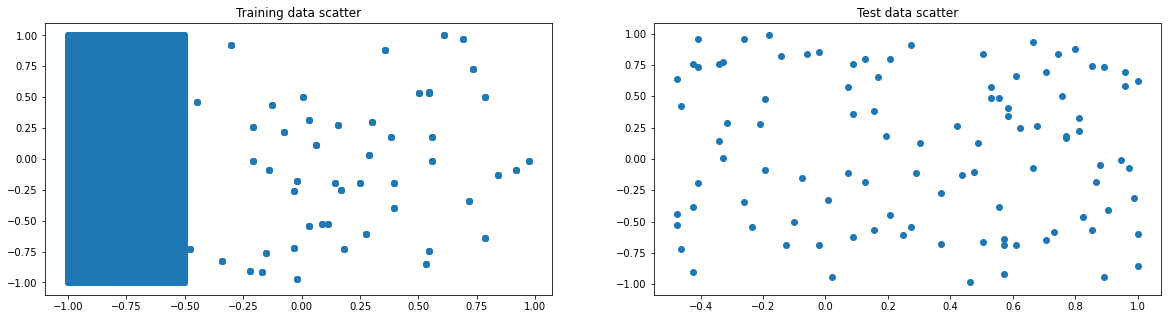

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5))
ax1.scatter(train_x[:,0], train_x[:,1])
ax1.set_title("Training data scatter")

ax2.scatter(test_x[:,0], test_x[:,1])
ax2.set_title("Test data scatter")
plt.show()

In [5]:
# There are much more training datapoints in the x0 region [-1.0, -0.5]
sparse_region_points = np.count_nonzero(train_x[:,0] > -0.5)
dense_region_points = train_x.shape[0] - sparse_region_points
print("Training data points in x0 region [-1.0, -0.5]:", dense_region_points)
print("Training data points in x0 region [-0.5, 1.0]:", sparse_region_points)

Training data points in x0 region [-1.0, -0.5]: 17100
Training data points in x0 region [-0.5, 1.0]: 150


Observe that we have an imbalanced dataset. The x0 region [-1.0, -0.5] is much denser than the x0 region [-0.5, 1.0]. Kernelized Gaussian Process Regression computational cost is O(N^3) for N data points. We can thus easily reduce the size of the data set without suffering a loss in prediction performance by subsampling the x0 region [-1.0, -0.5].

## Heat map of water pollution in the training data

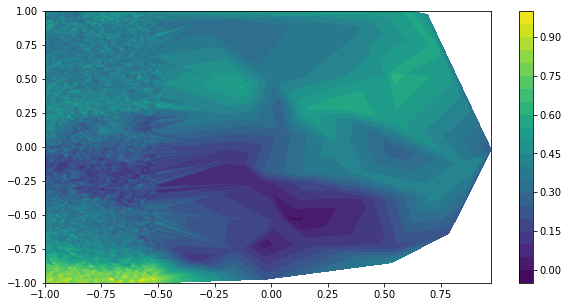

In [6]:
# note: 1.00 = fully poluted, 0.00 = fully clean
fig, ax = plt.subplots(figsize=(10,5))
tcf = ax.tricontourf(train_x[:,0], train_x[:,1], train_y, 20)
fig.colorbar(tcf)
plt.show()

# Preprocessing

In [20]:
# number of data point sampled from the dense x0 region [-1.0, -0.5]
num_dense_samples = 1500

# separate all the valuable datapoints
train_x_sparse = train_x[train_x[:,0] > -0.5]
train_y_sparse = train_y[train_x[:,0] > -0.5]

train_x_dense = train_x[train_x[:,0] <= -0.5]
train_y_dense = train_y[train_x[:,0] <= -0.5]

dense_data = np.concatenate([train_x_dense, train_y_dense.reshape(-1, 1)], axis=1)
np.random.shuffle(dense_data)

# random shuffle datapoints in the dense region and select 150 to balance the data
train_x_dense_sampled = dense_data[:num_dense_samples,:2]
train_y_dense_sampled = dense_data[:num_dense_samples,2]

assert train_x_dense_sampled.shape[0] == num_dense_samples
assert train_y_dense_sampled.shape[0] == num_dense_samples

# do the train-validation split evenly in the dense and the sparse region
X_train_sparse, X_val_sparse, y_train_sparse, y_val_sparse = train_test_split(train_x_sparse, train_y_sparse, test_size=0.2, random_state=42)
X_train_dense, X_val_dense, y_train_dense, y_val_dense = train_test_split(train_x_dense_sampled, train_y_dense_sampled, test_size=0.33, random_state=42)

X_train = np.concatenate([X_train_sparse, X_train_dense], axis=0)
y_train = np.concatenate([y_train_sparse, y_train_dense])
X_val = np.concatenate([X_val_sparse, X_val_dense], axis=0)
y_val = np.concatenate([y_val_sparse, y_val_dense])

print("Sampled X_train shape:", X_train.shape)
print("Sampled y_train shape:", y_train.shape)
print("Sampled X_val shape:", X_val.shape)
print("Sampled y_val shape:", y_val.shape)

Sampled X_train shape: (1125, 2)
Sampled y_train shape: (1125,)
Sampled X_val shape: (525, 2)
Sampled y_val shape: (525,)


## Visualize training and validation set

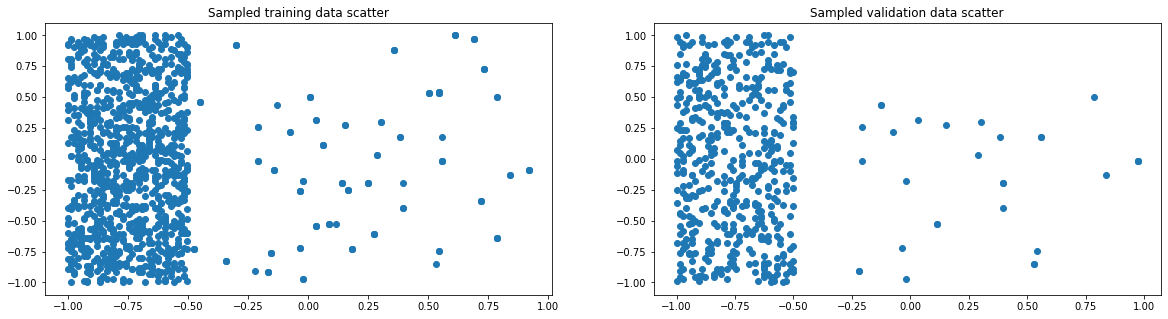

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5))
ax1.scatter(X_train[:,0], X_train[:,1])
ax1.set_title("Sampled training data scatter")
ax2.scatter(X_val[:,0], X_val[:,1])
ax2.set_title("Sampled validation data scatter")
plt.show()

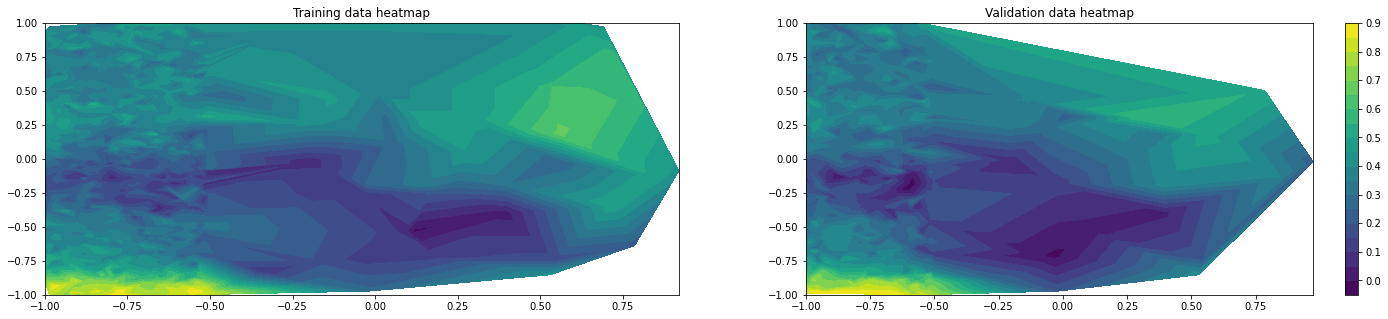

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25,5))
tcf1 = ax1.tricontourf(X_train[:,0], X_train[:,1], y_train, 20)
ax1.set_title("Training data heatmap")
tcf2 = ax2.tricontourf(X_val[:,0], X_val[:,1], y_val, 20)
ax2.set_title("Validation data heatmap")

fig.colorbar(tcf1)
plt.show()

In [10]:
# scale X data to 0-mean and unit variance
scaler = StandardScaler().fit(X_train)

# Model selection

## Exact Gaussian Process Regression

### Base model

In [11]:
k = ker.Matern() + ker.ConstantKernel()
gpr = gp.GaussianProcessRegressor(kernel=k, alpha=0.01, n_restarts_optimizer=50, random_state=42)
noisyMat_gpr = pipeline.Pipeline([
    #("scaler", scaler),
    ("gpr", gpr)
])

print("Fitting noisy Matern kernel GPR")
start = time()
noisyMat_gpr.fit(X_train, y_train)
y_val_hat, std = noisyMat_gpr.predict(X_val, return_std=True)
score = cost_function(y_val, y_val_hat)
print("Took {} seconds, score = {}".format(time() - start, score))

Fitting noisy Matern kernel GPR
Took 228.9841010570526 seconds, score = 0.025482535937280504


### Noisy Matern Kernel

In [57]:
grid = {
    "length_scale": [0.01, 0.05, 0.1, 0.5],
    "nu": [0.5, 1.5, 2.5],
    "kernel_noise": [1e-5, 1e-3, 0.1],
    "safety_increase": [0.1, 0.2]
}

gpr = gp.GaussianProcessRegressor(kernel=None, alpha=0.01, n_restarts_optimizer=5, random_state=42, normalize_y=True)
noisyMat_gpr = pipeline.Pipeline([
    ("scaler", scaler),
    ("gpr", gpr)
])

matern_scores = []
params_list = ParameterGrid(grid)
for params in params_list:
    k = ker.Matern(length_scale=params['length_scale'], nu=params['nu']) + \
        ker.WhiteKernel(noise_level=params['kernel_noise'])
    noisyMat_gpr.set_params(**{
      "gpr__kernel": k,
    })

    print("Fitting noisy Matern GPR for", params)
    start = time()
    noisyMat_gpr.fit(X_train, y_train)
    
    y_val_hat = noisyMat_gpr.predict(X_val)
    # we add a safety increase to 'safe' predictions since false negatives are penalized harshly
    predict_safe = (y_val_hat < THRESHOLD).astype(int)
    y_val_hat += params['safety_increase'] * predict_safe
    score = cost_function(y_val, y_val_hat)
    matern_scores.append(score)

    print("Took {} seconds, score = {}".format(time() - start, score))

matern_scores_min = min(matern_scores)
best_params = params_list[matern_scores.index(matern_scores_min)]

print("Best score: {}\nParams: {}".format(matern_scores_min, best_params))

Fitting noisy Matern GPR for {'kernel_noise': 1e-05, 'length_scale': 0.01, 'nu': 0.5, 'safety_increase': 0.1}


/home/yannick/.local/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:1624: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


Took 20.796271324157715 seconds, score = -0.007723926012597082
Fitting noisy Matern GPR for {'kernel_noise': 1e-05, 'length_scale': 0.01, 'nu': 0.5, 'safety_increase': 0.2}


/home/yannick/.local/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:1624: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


Took 21.082725048065186 seconds, score = 0.05148625177914602
Fitting noisy Matern GPR for {'kernel_noise': 1e-05, 'length_scale': 0.01, 'nu': 1.5, 'safety_increase': 0.1}
Took 34.44386696815491 seconds, score = -0.008169898384813351
Fitting noisy Matern GPR for {'kernel_noise': 1e-05, 'length_scale': 0.01, 'nu': 1.5, 'safety_increase': 0.2}
Took 34.87617897987366 seconds, score = 0.0508230352070479
Fitting noisy Matern GPR for {'kernel_noise': 1e-05, 'length_scale': 0.01, 'nu': 2.5, 'safety_increase': 0.1}
Took 35.61473798751831 seconds, score = -0.008795952305301622
Fitting noisy Matern GPR for {'kernel_noise': 1e-05, 'length_scale': 0.01, 'nu': 2.5, 'safety_increase': 0.2}
Took 36.67280292510986 seconds, score = 0.05062535449267608
Fitting noisy Matern GPR for {'kernel_noise': 1e-05, 'length_scale': 0.05, 'nu': 0.5, 'safety_increase': 0.1}


/home/yannick/.local/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:1624: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


Took 20.91750407218933 seconds, score = -0.007723926037339861
Fitting noisy Matern GPR for {'kernel_noise': 1e-05, 'length_scale': 0.05, 'nu': 0.5, 'safety_increase': 0.2}


/home/yannick/.local/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:1624: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


Took 21.135132789611816 seconds, score = 0.05148625175646371
Fitting noisy Matern GPR for {'kernel_noise': 1e-05, 'length_scale': 0.05, 'nu': 1.5, 'safety_increase': 0.1}
Took 32.99293541908264 seconds, score = -0.008169898384813351
Fitting noisy Matern GPR for {'kernel_noise': 1e-05, 'length_scale': 0.05, 'nu': 1.5, 'safety_increase': 0.2}
Took 32.46347498893738 seconds, score = 0.0508230352070479
Fitting noisy Matern GPR for {'kernel_noise': 1e-05, 'length_scale': 0.05, 'nu': 2.5, 'safety_increase': 0.1}
Took 33.43960762023926 seconds, score = -0.008795952305301622
Fitting noisy Matern GPR for {'kernel_noise': 1e-05, 'length_scale': 0.05, 'nu': 2.5, 'safety_increase': 0.2}
Took 34.608670711517334 seconds, score = 0.05062535449267608
Fitting noisy Matern GPR for {'kernel_noise': 1e-05, 'length_scale': 0.1, 'nu': 0.5, 'safety_increase': 0.1}


/home/yannick/.local/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:1624: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


Took 21.181036710739136 seconds, score = -0.007723925812863779
Fitting noisy Matern GPR for {'kernel_noise': 1e-05, 'length_scale': 0.1, 'nu': 0.5, 'safety_increase': 0.2}


/home/yannick/.local/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:1624: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


Took 20.295798778533936 seconds, score = 0.05148625196102697
Fitting noisy Matern GPR for {'kernel_noise': 1e-05, 'length_scale': 0.1, 'nu': 1.5, 'safety_increase': 0.1}
Took 30.784699201583862 seconds, score = -0.008169898384813351
Fitting noisy Matern GPR for {'kernel_noise': 1e-05, 'length_scale': 0.1, 'nu': 1.5, 'safety_increase': 0.2}
Took 30.697450399398804 seconds, score = 0.0508230352070479
Fitting noisy Matern GPR for {'kernel_noise': 1e-05, 'length_scale': 0.1, 'nu': 2.5, 'safety_increase': 0.1}
Took 32.902167081832886 seconds, score = -0.00879595222000352
Fitting noisy Matern GPR for {'kernel_noise': 1e-05, 'length_scale': 0.1, 'nu': 2.5, 'safety_increase': 0.2}
Took 32.86539697647095 seconds, score = 0.05062535455584949
Fitting noisy Matern GPR for {'kernel_noise': 1e-05, 'length_scale': 0.5, 'nu': 0.5, 'safety_increase': 0.1}


/home/yannick/.local/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:1624: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


Took 19.93438148498535 seconds, score = -0.007723925812863779
Fitting noisy Matern GPR for {'kernel_noise': 1e-05, 'length_scale': 0.5, 'nu': 0.5, 'safety_increase': 0.2}


/home/yannick/.local/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:1624: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


Took 20.034759283065796 seconds, score = 0.05148625196102697
Fitting noisy Matern GPR for {'kernel_noise': 1e-05, 'length_scale': 0.5, 'nu': 1.5, 'safety_increase': 0.1}
Took 27.871527433395386 seconds, score = -0.008169898384813351
Fitting noisy Matern GPR for {'kernel_noise': 1e-05, 'length_scale': 0.5, 'nu': 1.5, 'safety_increase': 0.2}
Took 27.856913566589355 seconds, score = 0.0508230352070479
Fitting noisy Matern GPR for {'kernel_noise': 1e-05, 'length_scale': 0.5, 'nu': 2.5, 'safety_increase': 0.1}
Took 29.31143808364868 seconds, score = -0.008795952305301622
Fitting noisy Matern GPR for {'kernel_noise': 1e-05, 'length_scale': 0.5, 'nu': 2.5, 'safety_increase': 0.2}
Took 31.189663410186768 seconds, score = 0.05062535449267608
Fitting noisy Matern GPR for {'kernel_noise': 0.001, 'length_scale': 0.01, 'nu': 0.5, 'safety_increase': 0.1}


/home/yannick/.local/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:1624: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


Took 19.08368158340454 seconds, score = -0.007723925812863779
Fitting noisy Matern GPR for {'kernel_noise': 0.001, 'length_scale': 0.01, 'nu': 0.5, 'safety_increase': 0.2}


/home/yannick/.local/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:1624: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


Took 18.052051305770874 seconds, score = 0.05148625196102697
Fitting noisy Matern GPR for {'kernel_noise': 0.001, 'length_scale': 0.01, 'nu': 1.5, 'safety_increase': 0.1}
Took 28.461768865585327 seconds, score = -0.008169898384813351
Fitting noisy Matern GPR for {'kernel_noise': 0.001, 'length_scale': 0.01, 'nu': 1.5, 'safety_increase': 0.2}
Took 28.779927015304565 seconds, score = 0.0508230352070479
Fitting noisy Matern GPR for {'kernel_noise': 0.001, 'length_scale': 0.01, 'nu': 2.5, 'safety_increase': 0.1}
Took 29.177027702331543 seconds, score = -0.008795952305301622
Fitting noisy Matern GPR for {'kernel_noise': 0.001, 'length_scale': 0.01, 'nu': 2.5, 'safety_increase': 0.2}
Took 29.068010568618774 seconds, score = 0.05062535449267608
Fitting noisy Matern GPR for {'kernel_noise': 0.001, 'length_scale': 0.05, 'nu': 0.5, 'safety_increase': 0.1}


/home/yannick/.local/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:1624: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


Took 19.030193328857422 seconds, score = -0.0077239260021055335
Fitting noisy Matern GPR for {'kernel_noise': 0.001, 'length_scale': 0.05, 'nu': 0.5, 'safety_increase': 0.2}


/home/yannick/.local/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:1624: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


Took 17.665045499801636 seconds, score = 0.05148625178822992
Fitting noisy Matern GPR for {'kernel_noise': 0.001, 'length_scale': 0.05, 'nu': 1.5, 'safety_increase': 0.1}
Took 27.79108953475952 seconds, score = -0.008169898384813351
Fitting noisy Matern GPR for {'kernel_noise': 0.001, 'length_scale': 0.05, 'nu': 1.5, 'safety_increase': 0.2}
Took 27.634552478790283 seconds, score = 0.0508230352070479
Fitting noisy Matern GPR for {'kernel_noise': 0.001, 'length_scale': 0.05, 'nu': 2.5, 'safety_increase': 0.1}
Took 28.054086923599243 seconds, score = -0.008795952305301622
Fitting noisy Matern GPR for {'kernel_noise': 0.001, 'length_scale': 0.05, 'nu': 2.5, 'safety_increase': 0.2}
Took 27.761620044708252 seconds, score = 0.05062535449267608
Fitting noisy Matern GPR for {'kernel_noise': 0.001, 'length_scale': 0.1, 'nu': 0.5, 'safety_increase': 0.1}


/home/yannick/.local/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:1624: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


Took 17.64021944999695 seconds, score = -0.007723926001059448
Fitting noisy Matern GPR for {'kernel_noise': 0.001, 'length_scale': 0.1, 'nu': 0.5, 'safety_increase': 0.2}


/home/yannick/.local/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:1624: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


Took 17.88141632080078 seconds, score = 0.05148625179095178
Fitting noisy Matern GPR for {'kernel_noise': 0.001, 'length_scale': 0.1, 'nu': 1.5, 'safety_increase': 0.1}
Took 28.65743613243103 seconds, score = -0.008169898384813351
Fitting noisy Matern GPR for {'kernel_noise': 0.001, 'length_scale': 0.1, 'nu': 1.5, 'safety_increase': 0.2}
Took 29.600642204284668 seconds, score = 0.0508230352070479
Fitting noisy Matern GPR for {'kernel_noise': 0.001, 'length_scale': 0.1, 'nu': 2.5, 'safety_increase': 0.1}
Took 29.364623308181763 seconds, score = -0.008795952305301622
Fitting noisy Matern GPR for {'kernel_noise': 0.001, 'length_scale': 0.1, 'nu': 2.5, 'safety_increase': 0.2}
Took 29.268936157226562 seconds, score = 0.05062535449267608
Fitting noisy Matern GPR for {'kernel_noise': 0.001, 'length_scale': 0.5, 'nu': 0.5, 'safety_increase': 0.1}


/home/yannick/.local/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:1624: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


Took 17.45914053916931 seconds, score = -0.007723926006795686
Fitting noisy Matern GPR for {'kernel_noise': 0.001, 'length_scale': 0.5, 'nu': 0.5, 'safety_increase': 0.2}


/home/yannick/.local/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:1624: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


Took 17.927459955215454 seconds, score = 0.05148625178436187
Fitting noisy Matern GPR for {'kernel_noise': 0.001, 'length_scale': 0.5, 'nu': 1.5, 'safety_increase': 0.1}
Took 30.88258194923401 seconds, score = -0.008169898384813351
Fitting noisy Matern GPR for {'kernel_noise': 0.001, 'length_scale': 0.5, 'nu': 1.5, 'safety_increase': 0.2}
Took 30.01226282119751 seconds, score = 0.0508230352070479
Fitting noisy Matern GPR for {'kernel_noise': 0.001, 'length_scale': 0.5, 'nu': 2.5, 'safety_increase': 0.1}
Took 30.62407660484314 seconds, score = -0.008795952305301622
Fitting noisy Matern GPR for {'kernel_noise': 0.001, 'length_scale': 0.5, 'nu': 2.5, 'safety_increase': 0.2}
Took 30.476614236831665 seconds, score = 0.05062535449267608
Fitting noisy Matern GPR for {'kernel_noise': 0.1, 'length_scale': 0.01, 'nu': 0.5, 'safety_increase': 0.1}


/home/yannick/.local/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:1624: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


Took 18.86149573326111 seconds, score = -0.007723925945822486
Fitting noisy Matern GPR for {'kernel_noise': 0.1, 'length_scale': 0.01, 'nu': 0.5, 'safety_increase': 0.2}


/home/yannick/.local/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:1624: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


Took 19.74684762954712 seconds, score = 0.05148625183974511
Fitting noisy Matern GPR for {'kernel_noise': 0.1, 'length_scale': 0.01, 'nu': 1.5, 'safety_increase': 0.1}
Took 31.206183910369873 seconds, score = -0.008169898384813351
Fitting noisy Matern GPR for {'kernel_noise': 0.1, 'length_scale': 0.01, 'nu': 1.5, 'safety_increase': 0.2}
Took 30.046587467193604 seconds, score = 0.0508230352070479
Fitting noisy Matern GPR for {'kernel_noise': 0.1, 'length_scale': 0.01, 'nu': 2.5, 'safety_increase': 0.1}
Took 30.663671493530273 seconds, score = -0.008795952305301622
Fitting noisy Matern GPR for {'kernel_noise': 0.1, 'length_scale': 0.01, 'nu': 2.5, 'safety_increase': 0.2}
Took 30.81251573562622 seconds, score = 0.05062535449267608
Fitting noisy Matern GPR for {'kernel_noise': 0.1, 'length_scale': 0.05, 'nu': 0.5, 'safety_increase': 0.1}


/home/yannick/.local/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:1624: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


Took 17.53768491744995 seconds, score = -0.007723926013505978
Fitting noisy Matern GPR for {'kernel_noise': 0.1, 'length_scale': 0.05, 'nu': 0.5, 'safety_increase': 0.2}


/home/yannick/.local/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:1624: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


Took 18.249587297439575 seconds, score = 0.05148625177833197
Fitting noisy Matern GPR for {'kernel_noise': 0.1, 'length_scale': 0.05, 'nu': 1.5, 'safety_increase': 0.1}
Took 29.907437562942505 seconds, score = -0.008169898384813351
Fitting noisy Matern GPR for {'kernel_noise': 0.1, 'length_scale': 0.05, 'nu': 1.5, 'safety_increase': 0.2}
Took 29.43319535255432 seconds, score = 0.0508230352070479
Fitting noisy Matern GPR for {'kernel_noise': 0.1, 'length_scale': 0.05, 'nu': 2.5, 'safety_increase': 0.1}
Took 28.761090755462646 seconds, score = -0.008795952305301622
Fitting noisy Matern GPR for {'kernel_noise': 0.1, 'length_scale': 0.05, 'nu': 2.5, 'safety_increase': 0.2}
Took 28.559359073638916 seconds, score = 0.05062535449267608
Fitting noisy Matern GPR for {'kernel_noise': 0.1, 'length_scale': 0.1, 'nu': 0.5, 'safety_increase': 0.1}


/home/yannick/.local/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:1624: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


Took 17.239968061447144 seconds, score = -0.007723925812863779
Fitting noisy Matern GPR for {'kernel_noise': 0.1, 'length_scale': 0.1, 'nu': 0.5, 'safety_increase': 0.2}


/home/yannick/.local/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:1624: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


Took 17.309179544448853 seconds, score = 0.05148625196102697
Fitting noisy Matern GPR for {'kernel_noise': 0.1, 'length_scale': 0.1, 'nu': 1.5, 'safety_increase': 0.1}
Took 27.266930103302002 seconds, score = -0.008169898384813351
Fitting noisy Matern GPR for {'kernel_noise': 0.1, 'length_scale': 0.1, 'nu': 1.5, 'safety_increase': 0.2}
Took 27.207083463668823 seconds, score = 0.0508230352070479
Fitting noisy Matern GPR for {'kernel_noise': 0.1, 'length_scale': 0.1, 'nu': 2.5, 'safety_increase': 0.1}
Took 27.307917594909668 seconds, score = -0.008795952305301622
Fitting noisy Matern GPR for {'kernel_noise': 0.1, 'length_scale': 0.1, 'nu': 2.5, 'safety_increase': 0.2}
Took 27.52553391456604 seconds, score = 0.05062535449267608
Fitting noisy Matern GPR for {'kernel_noise': 0.1, 'length_scale': 0.5, 'nu': 0.5, 'safety_increase': 0.1}


/home/yannick/.local/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:1624: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


Took 16.85533595085144 seconds, score = -0.007723926081858474
Fitting noisy Matern GPR for {'kernel_noise': 0.1, 'length_scale': 0.5, 'nu': 0.5, 'safety_increase': 0.2}


/home/yannick/.local/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:1624: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


Took 16.620672464370728 seconds, score = 0.051486251716282044
Fitting noisy Matern GPR for {'kernel_noise': 0.1, 'length_scale': 0.5, 'nu': 1.5, 'safety_increase': 0.1}
Took 26.54027771949768 seconds, score = -0.008169898384813351
Fitting noisy Matern GPR for {'kernel_noise': 0.1, 'length_scale': 0.5, 'nu': 1.5, 'safety_increase': 0.2}
Took 26.50360369682312 seconds, score = 0.0508230352070479
Fitting noisy Matern GPR for {'kernel_noise': 0.1, 'length_scale': 0.5, 'nu': 2.5, 'safety_increase': 0.1}
Took 27.748751163482666 seconds, score = -0.008795952305301622
Fitting noisy Matern GPR for {'kernel_noise': 0.1, 'length_scale': 0.5, 'nu': 2.5, 'safety_increase': 0.2}
Took 27.531742334365845 seconds, score = 0.05062535449267608
Best score: -0.008795952305301622
Params: {'safety_increase': 0.1, 'nu': 2.5, 'length_scale': 0.01, 'kernel_noise': 1e-05}


### Kernel sum

In [ ]:
grid = {
    "rbf": [0.0, 1.0, 2.0],
    "matern": [0.0, 1.0, 2.0],
    "rq": [0.0, 1.0, 2.0],
    "white": [0.0, 1.0, 2.0]    
}

gpr = gp.GaussianProcessRegressor(kernel=None, n_restarts_optimizer=5, random_state=42, normalize_y=True)
sumKernel_gpr = pipeline.Pipeline([
    ("scaler", scaler),
    ("gpr", gpr)
])

sumKernel_scores = []
params_list = ParameterGrid(grid)
for params in params_list:
    k = params['rbf'] * ker.RBF() + params['matern'] * ker.Matern() + params['rq'] * ker.RationalQuadratic() + params['white'] * ker.WhiteKernel()
    sumKernel_gpr.set_params(**{
      "gpr__kernel": k,
    })

    print("Fitting sum kernel GPR for", params)
    start = time()
    sumKernel_gpr.fit(X_train, y_train)
    y_val_hat = sumKernel_gpr.predict(X_val)
    score = cost_function(y_val, y_val_hat)
    print("Took {} seconds, score = {}".format(time() - start, score))
    sumKernel_scores.append(score)

sumKernel_scores_min = min(sumKernel_scores)
best_params = params_list[sumKernel_scores.index(sumKernel_scores_min)]

print("Best score: {}\nParams: {}".format(matern_scores_min, best_params))

### Matern + Rational Quadratic + WhiteNoise

In [15]:
grid = {
    "length_scale": [0.01, 0.05, 0.1, 0.5],
    "kernel_noise": [1e-5, 1e-3],
    "alpha": [0.1, 0.5, 1.0, 3.0],
    "safety_increase": [0.1, 0.2]
}

gpr = gp.GaussianProcessRegressor(kernel=None, alpha=0.01, n_restarts_optimizer=5, random_state=42, normalize_y=True)
noisyMatRQ_gpr = pipeline.Pipeline([
    ("scaler", scaler),
    ("gpr", gpr)
])

maternRQ_scores = []
params_list = ParameterGrid(grid)
for params in params_list:
    k = ker.Matern(length_scale=0.01, nu=2.5) + \
        ker.RationalQuadratic(length_scale=params['length_scale'], alpha=params['alpha']) + \
        ker.WhiteKernel(noise_level=params['kernel_noise'])
    noisyMatRQ_gpr.set_params(**{
      "gpr__kernel": k,
    })

    print("Fitting noisy additive Matern RQ GPR for", params)
    start = time()
    noisyMatRQ_gpr.fit(X_train, y_train)
    
    y_val_hat = noisyMatRQ_gpr.predict(X_val)
    # we add a safety increase to 'safe' predictions since false negatives are penalized harshly
    predict_safe = (y_val_hat < THRESHOLD).astype(int)
    y_val_hat += params['safety_increase'] * predict_safe
    score = cost_function(y_val, y_val_hat)
    maternRQ_scores.append(score)

    print("Took {} seconds, score = {}".format(time() - start, score))

maternRQ_scores_min = min(maternRQ_scores)
best_params = params_list[maternRQ_scores.index(maternRQ_scores_min)]

print("Best score: {}\nParams: {}".format(maternRQ_scores_min, best_params))

Fitting noisy additive Matern RQ GPR for {'alpha': 0.1, 'kernel_noise': 1e-05, 'length_scale': 0.01, 'safety_increase': 0.1}
Took 88.95418787002563 seconds, score = -0.00866591700486842
Fitting noisy additive Matern RQ GPR for {'alpha': 0.1, 'kernel_noise': 1e-05, 'length_scale': 0.01, 'safety_increase': 0.2}
Took 84.11932325363159 seconds, score = 0.05114440434967343
Fitting noisy additive Matern RQ GPR for {'alpha': 0.1, 'kernel_noise': 1e-05, 'length_scale': 0.05, 'safety_increase': 0.1}
Took 76.99688076972961 seconds, score = -0.008883996511750673
Fitting noisy additive Matern RQ GPR for {'alpha': 0.1, 'kernel_noise': 1e-05, 'length_scale': 0.05, 'safety_increase': 0.2}
Took 75.47270774841309 seconds, score = 0.05081555188415063
Fitting noisy additive Matern RQ GPR for {'alpha': 0.1, 'kernel_noise': 1e-05, 'length_scale': 0.1, 'safety_increase': 0.1}
Took 72.15975832939148 seconds, score = -0.00888398930996869
Fitting noisy additive Matern RQ GPR for {'alpha': 0.1, 'kernel_noise': 

Took 71.53296089172363 seconds, score = -0.008665923050570727
Fitting noisy additive Matern RQ GPR for {'alpha': 1.0, 'kernel_noise': 0.001, 'length_scale': 0.1, 'safety_increase': 0.2}
Took 71.5097119808197 seconds, score = 0.05114440138483134
Fitting noisy additive Matern RQ GPR for {'alpha': 1.0, 'kernel_noise': 0.001, 'length_scale': 0.5, 'safety_increase': 0.1}
Took 66.18154788017273 seconds, score = -0.008733327870381249
Fitting noisy additive Matern RQ GPR for {'alpha': 1.0, 'kernel_noise': 0.001, 'length_scale': 0.5, 'safety_increase': 0.2}
Took 66.65371680259705 seconds, score = 0.050976536207280765
Fitting noisy additive Matern RQ GPR for {'alpha': 3.0, 'kernel_noise': 1e-05, 'length_scale': 0.01, 'safety_increase': 0.1}
Took 65.59893083572388 seconds, score = -0.008883997376302497
Fitting noisy additive Matern RQ GPR for {'alpha': 3.0, 'kernel_noise': 1e-05, 'length_scale': 0.01, 'safety_increase': 0.2}
Took 65.69751787185669 seconds, score = 0.050815555490804826
Fitting noi

### Matern + RBF + WhiteNoise

In [16]:
grid = {
    "length_scale": [0.01, 0.05, 0.1, 0.2, 0.5],
    "kernel_noise": [1e-5, 1e-3],
    "safety_increase": [0.1, 0.15, 0.2]
}

gpr = gp.GaussianProcessRegressor(kernel=None, alpha=0.01, n_restarts_optimizer=10, random_state=42, normalize_y=True)
noisyMatRBF_gpr = pipeline.Pipeline([
    ("scaler", scaler),
    ("gpr", gpr)
])

maternRBF_scores = []
params_list = ParameterGrid(grid)
for params in params_list:
    k = ker.Matern(length_scale=0.01, nu=2.5) + \
        ker.RBF(length_scale=params['length_scale']) + \
        ker.WhiteKernel(noise_level=params['kernel_noise'])
    noisyMatRBF_gpr.set_params(**{
      "gpr__kernel": k,
    })

    print("Fitting noisy additive Matern RBF GPR for", params)
    start = time()
    noisyMatRBF_gpr.fit(X_train, y_train)
    
    y_val_hat = noisyMatRBF_gpr.predict(X_val)
    # we add a safety increase to 'safe' predictions since false negatives are penalized harshly
    predict_safe = (y_val_hat < THRESHOLD).astype(int)
    y_val_hat += params['safety_increase'] * predict_safe
    score = cost_function(y_val, y_val_hat)
    maternRBF_scores.append(score)

    print("Took {} seconds, score = {}".format(time() - start, score))

maternRBF_scores_min = min(maternRBF_scores)
best_params = params_list[maternRBF_scores.index(maternRBF_scores_min)]

print("Best score: {}\nParams: {}".format(maternRBF_scores_min, best_params))

Fitting noisy additive Matern RBF GPR for {'kernel_noise': 1e-05, 'length_scale': 0.01, 'safety_increase': 0.1}
Took 67.3287181854248 seconds, score = -0.008883995882471438
Fitting noisy additive Matern RBF GPR for {'kernel_noise': 1e-05, 'length_scale': 0.01, 'safety_increase': 0.15}
Took 68.26244187355042 seconds, score = 0.025428077376692202
Fitting noisy additive Matern RBF GPR for {'kernel_noise': 1e-05, 'length_scale': 0.01, 'safety_increase': 0.2}
Took 67.25150489807129 seconds, score = 0.05081554653609223
Fitting noisy additive Matern RBF GPR for {'kernel_noise': 1e-05, 'length_scale': 0.05, 'safety_increase': 0.1}
Took 68.19657945632935 seconds, score = -0.00888399640814532
Fitting noisy additive Matern RBF GPR for {'kernel_noise': 1e-05, 'length_scale': 0.05, 'safety_increase': 0.15}
Took 68.98073744773865 seconds, score = 0.02542807822489088
Fitting noisy additive Matern RBF GPR for {'kernel_noise': 1e-05, 'length_scale': 0.05, 'safety_increase': 0.2}
Took 67.36834836006165 

## Approximate Gaussian Process Regression

### Fourier approximation
Approximates feature map of an RBF kernel by Monte Carlo approximation of its Fourier transform.

In [51]:
# create sampler and Gaussian process regressor pipeline
feature_map_fourier = RBFSampler(random_state=42, n_components=20)
gpr = gp.GaussianProcessRegressor(kernel=RBF(length_scale=5), n_restarts_optimizer=10, random_state=42)
fourier_approx_gpr = pipeline.Pipeline([
    ("scaler", scaler),
    ("feature_map", feature_map_fourier),
    ("gpr", gpr)
])

print("Fitting Gaussian Approx GPR")
start = time()
fourier_approx_gpr.fit(X_train, y_train)
y_val_hat, std = fourier_approx_gpr.predict(X_val, return_std=True)
score = cost_function(y_val, y_val_hat)
print("Took {} seconds, score = {}, std = {}".format(time() - start, score, std.shape))

Fitting Gaussian Approx GPR
Took 3.972454071044922 seconds, score = 0.31845493014161863, std = (230,)


/home/yannick/.local/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


In [ ]:
grid = {
    "feature_map__gamma": [0.01, 0.05, 0.1, 0.2, 0.5, 1],
    "feature_map__n_components": 100 * np.arange(1, 20),
    "gpr__alpha": [0.01, 0.05, 0.1, 0.2, 0.5]
}
# create sampler and Gaussian process regressor pipeline
feature_map_fourier = RBFSampler(random_state=42)
gpr = gp.GaussianProcessRegressor(kernel=RBF(), n_restarts_optimizer=10, random_state=42)
fourier_approx_gpr = pipeline.Pipeline([
    ("scaler", scaler),
    ("feature_map", feature_map_fourier),
    ("gpr", gpr)
])

fourier_scores = []
params_list = ParameterGrid(grid)
for params in ParameterGrid(grid):
    fourier_approx_gpr.set_params(**params)
    print("Fitting Gaussian Approx GPR with parameters", params)
    start = time()
    fourier_approx_gpr.fit(X_train, y_train)
    score = cost_function(y_val, fourier_approx_gpr.predict(X_val))
    print("Took {} seconds, score = {}".format(time() - start, score))
    fourier_scores.append(score)
    
fourier_scores_min = min(fourier_scores)
best_params = params_list[fourier_scores.index(fourier_scores_min)]

print("Best score: {}\nParams: {}".format(fourier_scores_min, best_params))

### Nyestroem approximation
Approximate a kernel map using a subset of the training data.

In [26]:
k = ker.Matern(nu=1.5) + ker.RationalQuadratic()
feature_map_nystroem = Nystroem(kernel=k, n_components=100, random_state=42)
gpr = gp.GaussianProcessRegressor(kernel=k, alpha=0.01, n_restarts_optimizer=10, random_state=42)
nystroem_gpr = pipeline.Pipeline([
    ("fmn", feature_map_nystroem),
    ("gpr", gpr)
])
start = time()
print("Training Nystroem GPR model")
nystroem_gpr.fit(X_train, y_train)
print("Took {} seconds".format(time() - start))

Training Nystroem GPR model
Took 89.28581380844116 seconds
